In [28]:
import numpy as np
import pandas as pd
from useful_tools import *
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [2]:
train_raw = pd.read_csv('data_sets/train.csv')

In [3]:
train = train_raw.drop(['ID','TARGET'],axis=1)
#train_x = train_x.reindex(np.random.permutation(train_x.index))
train_x = preprocessing.scale(train)
train_y = train_raw['TARGET'].values

/Users/mayen/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:153: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [4]:
class0 = train_x[train_y == 0]
class1 = train_x[train_y == 1]

In [5]:
def train_test_eqaul(train_x,train_y,split=0.5):
    class0idx = train_y==0
    class1idx = train_y==1
    class0 = train_x[class0idx]
    class1 = train_x[class1idx]
    n0,n1 = len(class0),len(class1)
    min_class = minor_class(train_y)
    if min_class:
        n_split = int(n1*split)
    else:
        n_split = int(n0*split)
    X_valid = np.vstack((class1[0:n_split],
                         class0[0:n_split]))
    Y_valid = np.concatenate((np.ones(n_split,dtype=int),
                              np.zeros(n_split,dtype=int)))
    
    X_train = np.vstack((class1[n_split:],
                         class0[n_split:]))
    Y_train = np.concatenate((np.ones(len(class1[n_split:]),dtype=int),
                              np.zeros(len(class0[n_split:]),dtype=int)))
    
    shuffle_train = np.random.choice(np.arange(len(Y_train)),len(Y_train),replace=False)
    shuffle_valid = np.random.choice(np.arange(len(Y_valid)),len(Y_valid),replace=False)
    
    return X_train[shuffle_train],Y_train[shuffle_train],X_valid[shuffle_valid],Y_valid[shuffle_valid]

def cross_validation(classifier,train_x,train_y,p_range,k=10,parameter='n_estimators',silence=True,**kwargs):
    errors = []
    for p in p_range:
        kfold = KFold(len(X_train), n_folds=k,shuffle=True)
        error = 0
        params = dict({parameter:p},**kwargs)
        for train_index, val_index in kfold:
            x_train = train_x[train_index]
            y_train = train_y[train_index]
            x_val = train_x[val_index]
            y_val = train_y[val_index]
            clf = classifier(**params)
            clf.fit(x_train,y_train)
            predictions = clf.predict(x_val)
            err = np.sum((predictions != y_val),dtype=float)/len(y_val)
            error += err/k
        if silence != True:
            print p,':',error
        errors.append(error)
    best = p_range[np.argmin(errors)]
    return best,errors

def major_class(train_y):
    n_class0 = np.sum(train_y == 0)
    n_class1 = np.sum(train_y == 1)
    if n_class0 > n_class1:
        return 0
    else:
        return 1
def minor_class(train_y):
    n_class0 = np.sum(train_y == 0)
    n_class1 = np.sum(train_y == 1)
    if n_class0 < n_class1:
        return 0
    else:
        return 1
    
def class_diff(train_y):
    n_class0 = np.sum(train_y == 0)
    n_class1 = np.sum(train_y == 1)
    min_class = minor_class(train_y)
    if min_class:
        class_diff = n_class0 - n_class1
    else:
        class_diff = n_class1 - n_class0
    return class_diff

def resample(train_x,train_y,k=5):
    '''Resample the data to fix class imbalance
        uses nearest neighbors method
        data should be scaled to mean 0 and std 1
        Returns synthetic data needed to balance
    '''
    min_class = minor_class(train_y)
    mc_data = train_x[train_y == min_class]
    cdiff = class_diff(train_y)
    
    nearest_neighbors = NearestNeighbors()
    nearest_neighbors.fit(mc_data)
    
    idxs = np.random.choice(np.arange(0,len(mc_data)),cdiff,replace=True)
    
    data_points = mc_data[idxs]
    dist,nni = nearest_neighbors.kneighbors(data_points,k)
    pivot_points = mc_data[nni[:,np.random.randint(0,k)]]
    print 'pp',pivot_points.shape
    print 'dp',data_points.shape
    scale = np.random.random(cdiff)[:,None]
    synthetic_data = data_points + scale*pivot_points

    return synthetic_data,min_class*np.ones(cdiff)

In [52]:
X_train,Y_train,X_valid,Y_valid = train_test_eqaul(train_x,train_y,split=0.5)
print Y_valid
print np.mean(Y_train)
print np.mean(Y_valid)

[1 1 0 ..., 0 1 1]
0.0205993535309
0.5


# Adaboost Random Forest

In [53]:
synthetic_data,synthetic_labels = resample(X_train,Y_train,k=5)

pp (70004, 369)
dp (70004, 369)


In [54]:
syn_train_x = np.vstack((X_train,synthetic_data))
syn_train_y = np.concatenate((Y_train,synthetic_labels))
shuffleidx = np.random.choice(np.arange(len(syn_train_y)),len(syn_train_y),replace=False)
sx_train = syn_train_x[shuffleidx]
sy_train = syn_train_y[shuffleidx]

In [55]:
# test class imbalance
print np.mean(train_y)
print np.mean(sy_train)

0.0395685345962
0.5


In [40]:
clf = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=42)
clf.fit(sx_train,sy_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [41]:
syn_predictions = clf.predict(X_valid)
print np.mean(predictions)
print error_rate(syn_predictions,Y_valid)

0.0100631412786
0.492686170213


In [56]:
clf = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=42)
clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [57]:
predictions = clf.predict(X_valid)
print np.mean(predictions)
print error_rate(predictions,Y_valid)

0.0109707446809
0.492353723404


In [46]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(cm))
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

0.0109707446809
0.492353723404


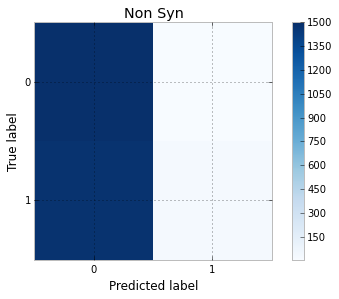

In [59]:
print np.mean(predictions)
plot_confusion_matrix(confusion_matrix(Y_valid,predictions),title='Non Syn')
print error_rate(predictions,Y_valid)

0.0106382978723
0.497340425532


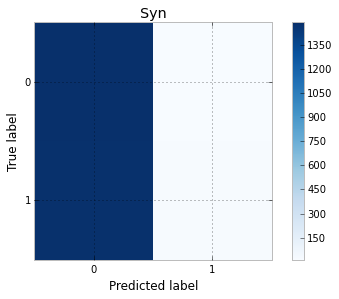

In [60]:
plot_confusion_matrix(confusion_matrix(Y_valid,syn_predictions),title='Syn')
print np.mean(syn_predictions)
print error_rate(syn_predictions,Y_valid)